In [259]:
# install relevant packages
import numpy as np
import matplotlib.pyplot as plt
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.utils import to_categorical 
import tensorflow as tf

import pymc3 as pm
import seaborn as sns
import sklearn
import theano
import theano.tensor as T
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from warnings import filterwarnings

In [3]:
## Generate a toy dataset for classification - overlap
# set number of samples
samples = 100
# generate data from MVN distribution
class_0 = np.random.multivariate_normal([-.5, -.5], .5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([.5, .5], .5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)

In [150]:
### ALT NN ARCHITECTURE
## Make NN for overlapping toy dataset
y_cat = to_categorical(y)
# create model
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
n_hidden = 8
model = Sequential()
model.add(Dense(n_hidden, input_dim=2, activation='tanh'))
model.add(Dense(n_hidden, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x, y_cat, epochs = 20, verbose = 0);

In [180]:
## Make NN for overlapping toy dataset
# create model
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
model = Sequential()
model.add(Dense(16, input_dim=2, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x, y, epochs = 10, verbose = 0);

Accuracy: 0.705


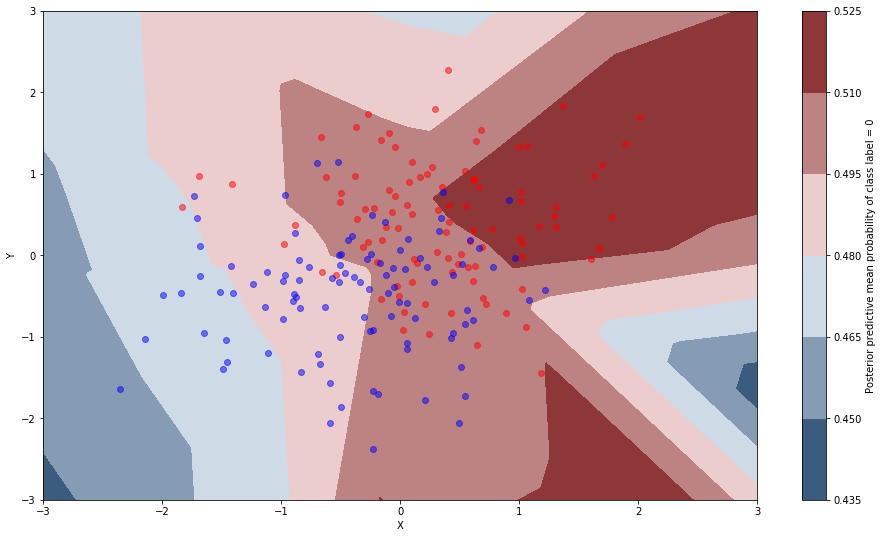

In [183]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
contour = ax.contourf(xx, yy, Z, cmap=cmap)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.5, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.5, color='blue', label='class 0')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0')
print(f"Accuracy: {np.mean((model.predict(x) > 0.5) * 1 == y.reshape(200,1))}");

In [249]:
## random subspace sampler
# list of models from different samples
models = []
# iterate over different samples
for i in range(10):
    # make a new NN with the same layout
    model2 = Sequential()
    model2.add(Dense(16, input_dim=2, activation='relu'))
    model2.add(Dense(4, activation='relu'))
    model2.add(Dense(1, activation='sigmoid'))
    # Compile model
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # add random vector to presaved model weights
    weights = [model.get_weights()[j] + np.random.normal(size = model.get_weights()[j].shape) for j in range(len(model.get_weights()))]
    model2.set_weights(weights)
    models.append(model2)

Accuracy: 0.7


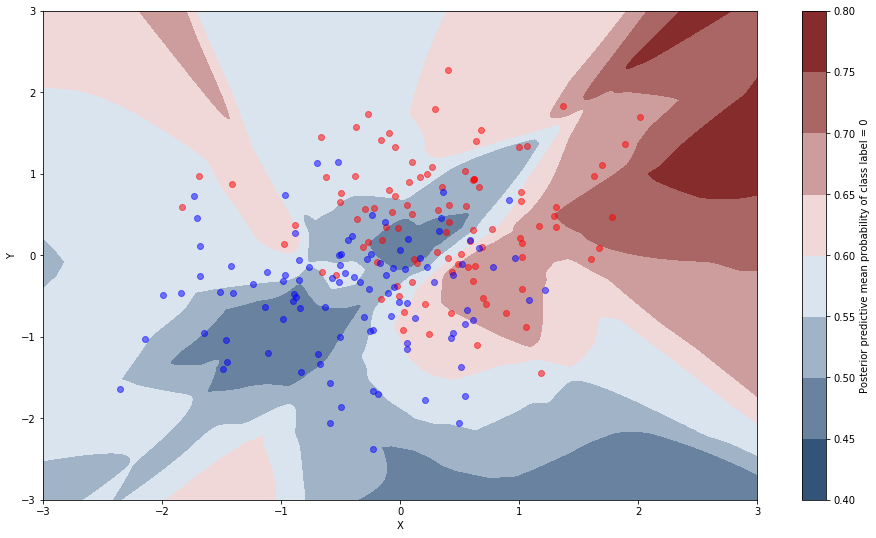

In [250]:
# p
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
preds = []
for model in models: 
    preds.append(model.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = np.concatenate(preds, axis = 1).mean(1).reshape(xx.shape)
contour = ax.contourf(xx, yy, Z, cmap=cmap)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.5, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.5, color='blue', label='class 0')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0')
print(f"Accuracy: {np.mean((model.predict(x) > 0.5) * 1 == y.reshape(200,1))}");

Accuracy: 0.7


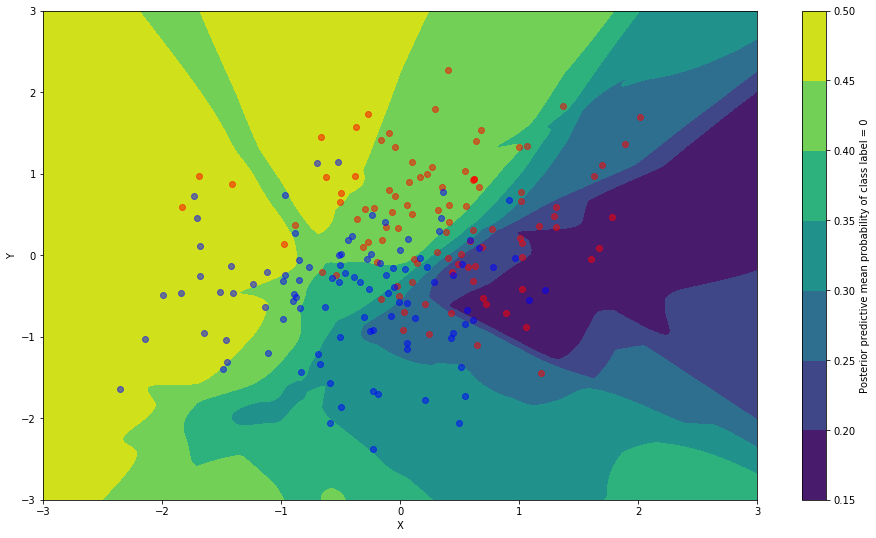

In [254]:
# p
fig, ax = plt.subplots(figsize=(16, 9))
Z = np.concatenate(preds, axis = 1).std(1).reshape(xx.shape)
contour = ax.contourf(xx, yy, Z)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.5, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.5, color='blue', label='class 0')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Standard deviation of predictive probability across subspace samples')

In [219]:
def construct_nn(ann_input, ann_output):

    floatX = theano.config.floatX
    # Initialize random weights between each layer
    init_1 = np.random.randn(2, 16).astype(floatX)
    init_2 = np.random.randn(16, 4).astype(floatX)
    init_out = np.random.randn(4).astype(floatX)
    
    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', x)
        ann_output = pm.Data('ann_output', y)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(x.shape[1], 16),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(16, 4),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(4,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = T.nnet.relu(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = T.nnet.relu(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=y.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(x, y)

In [215]:
### OLD CODE: CLOSER TO EXAMPLE
def construct_nn(ann_input, ann_output):
    n_hidden = 5

    # Initialize random weights between each layer
    init_1 = np.random.randn(x.shape[1], n_hidden).astype(floatX)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
    init_out = np.random.randn(n_hidden).astype(floatX)

    with pm.Model() as neural_network:
        # Trick: Turn inputs and outputs into shared variables using the data container pm.Data
        # It's still the same thing, but we can later change the values of the shared variable
        # (to switch in the test-data later) and pymc3 will just use the new data.
        # Kind-of like a pointer we can redirect.
        # For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
        ann_input = pm.Data('ann_input', x)
        ann_output = pm.Data('ann_output', y)

        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sigma=1,
                                 shape=(x.shape[1], n_hidden),
                                 testval=init_1)

        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sigma=1,
                                shape=(n_hidden, n_hidden),
                                testval=init_2)

        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sigma=1,
                                  shape=(n_hidden,),
                                  testval=init_out)

        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input,
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1,
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2,
                                              weights_2_out))

        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out',
                           act_out,
                           observed=ann_output,
                           total_size=y.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

neural_network = construct_nn(x, y)

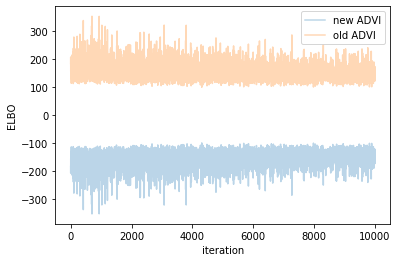

In [108]:
plt.plot(-inference.hist, label='new ADVI', alpha=.3)
plt.plot(approx.hist, label='old ADVI', alpha=.3)
plt.legend()
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [220]:
# fit the ADVI
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))
with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=30000, method=inference)
# get predictions
# create symbolic input
x_sym = T.matrix('X')
# symbolic number of samples is supported, we build vectorized posterior on the fly
n_sym = T.iscalar('n')
# Do not forget test_values or set theano.config.compute_test_value = 'off'
x_sym.tag.test_value = np.empty_like(x)
n_sym.tag.test_value = x.shape[1]
_sample_proba = approx.sample_node(neural_network.out.distribution.p,
                                   size=n_sym,
                                   more_replacements={neural_network['ann_input']: x_sym})
# Efficient vectorized form of sampling is used
sample_proba = theano.function([x_sym, n_sym], _sample_proba)
pred = (sample_proba(x, 500).mean(0) > 0.5) * 1
print('Accuracy = {}%'.format((y == pred).mean() * 100))

Finished [100%]: Average Loss = 124.32


Accuracy = 79.0%


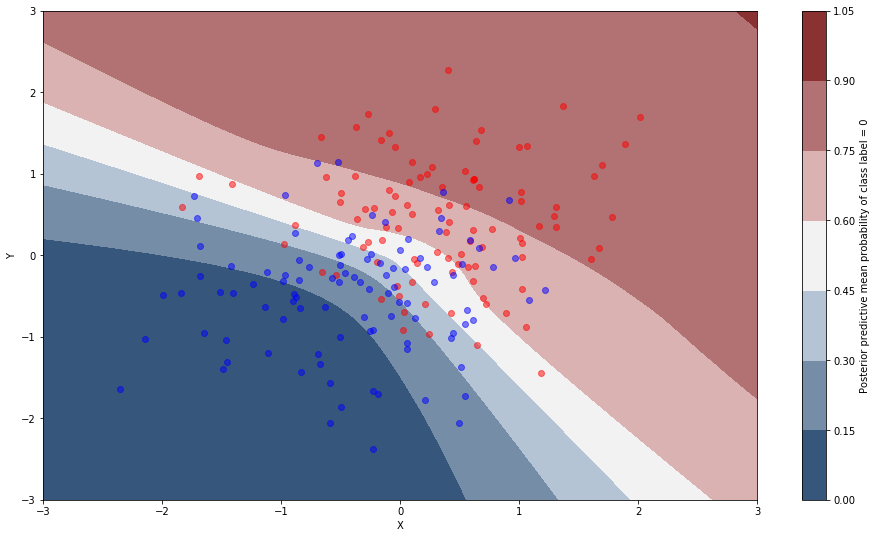

In [221]:
## Plot decision probabilities
# make grid for plot
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
# populate grid with average predictions
ppc = sample_proba(grid_2d ,500)
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
# print points with real classes
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.5, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.5, color='blue', label='class 0')
#ax.scatter(x[pred[:,0]==0, 0], x[pred[:,0]==0, 1])
#ax.scatter(x[pred[:,0]==1, 0], x[pred[:,0]==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

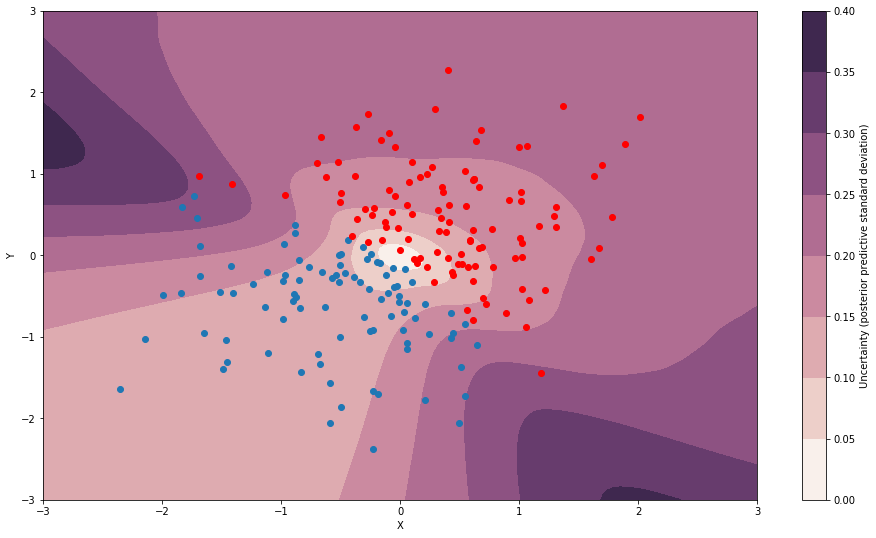

In [222]:
## uncertainty plot ()
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(x[pred==0, 0], x[pred==0, 1])
ax.scatter(x[pred==1, 0], x[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [261]:
### ANITA'S DATA
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
NN_model = Sequential(name="NN_model")
NN_model.add(Dense(5, activation="tanh", input_shape=(X_train.shape[1],)))
NN_model.add(Dense(5, activation="tanh"))
NN_model.add(Dense(1, activation="sigmoid"))
NN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
NN_history = NN_model.fit(X_train, Y_train, validation_split=0.2, epochs=800, callbacks=[early_stopping], verbose = 0)

In [262]:
## random subspace sampler
# list of models from different samples
models = []
# iterate over different samples
for i in range(10):
    # make a new NN with the same layout
    model2 = Sequential()
    model2.add(Dense(5, activation="tanh", input_shape=(X_train.shape[1],)))
    model2.add(Dense(5, activation="tanh"))
    model2.add(Dense(1, activation="sigmoid"))
    # Compile model
    model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # add random vector to presaved model weights
    weights = [NN_model.get_weights()[j] + np.random.normal(size = NN_model.get_weights()[j].shape) for j in range(len(NN_model.get_weights()))]
    model2.set_weights(weights)
    models.append(model2)

Accuracy: 0.7


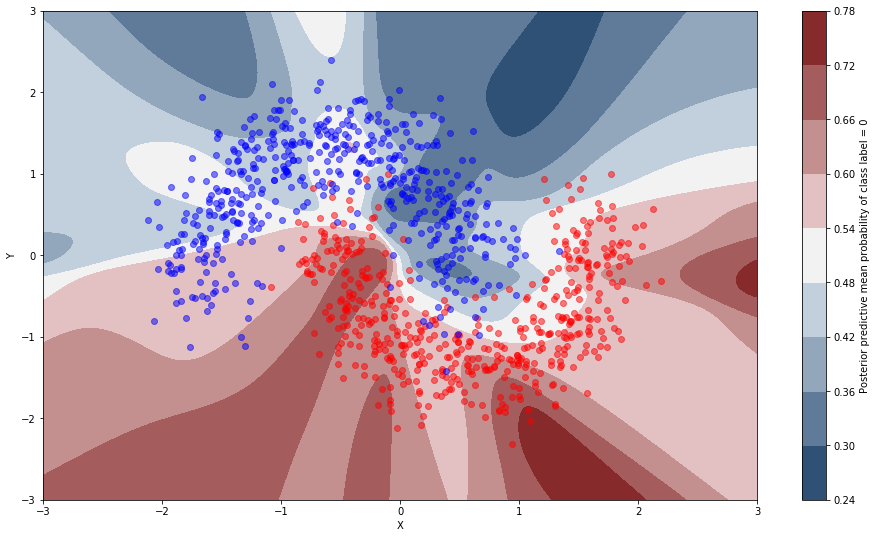

In [263]:
# p
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
preds = []
for model in models: 
    preds.append(model.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = np.concatenate(preds, axis = 1).mean(1).reshape(xx.shape)
contour = ax.contourf(xx, yy, Z, cmap=cmap)
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], alpha=0.5, color='red', label='class 1')
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], alpha=0.5, color='blue', label='class 0')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0')

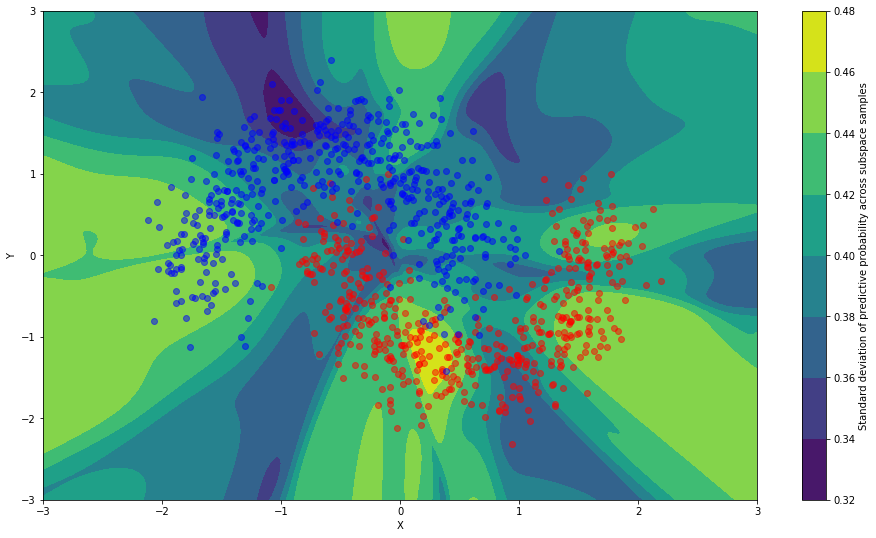

In [265]:
# p
fig, ax = plt.subplots(figsize=(16, 9))
Z = np.concatenate(preds, axis = 1).std(1).reshape(xx.shape)
contour = ax.contourf(xx, yy, Z)
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], alpha=0.5, color='red', label='class 1')
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], alpha=0.5, color='blue', label='class 0')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Standard deviation of predictive probability across subspace samples');